# 0) Import packages

In [3]:
#Import packages
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats

# 1) Introduction

The aim of today is first to present several model of random graph.

Then, we will pick one of them and try to choose the parameter to fit a graph in a naive way.

# 2) Project (Week 9)


a) Program preferential attachment by hand using only basic functions of networkx such that 1 node appears by stage and creates m links.

b) Compute in your graph what is the average degree.

c) Choose the parameter m that an average degree in the random graph closest to the one of your graph

d) Compare the two graphs in terms of at least two caracteristics:
average clustering, degree distributions, transitivity, average distance from one node, diameter, any centrality distribution,.... 

e) (Optional) Provide any variant to improve the prediction

# 3) Erdős–Rényi model

Let me remind that in an Erdős–Rényi model, each edge has probability p to be there.

In [38]:
N=100
p = 0.05


###  With networkx

In [39]:
#Create the graph using networkx
G= nx.erdos_renyi_graph(N,p) 

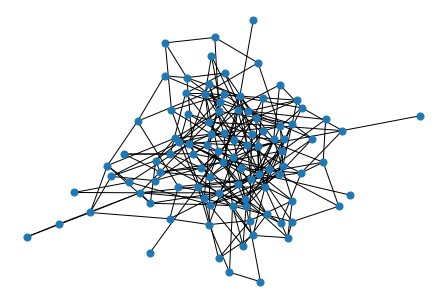

In [40]:
#draw G
nx.draw(G,node_size=50)
plt.show()

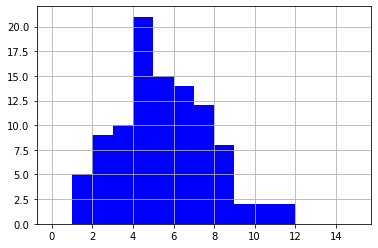

In [19]:
data_degree=[G.degree(n) for n in G.nodes()] # List of degrees
pt = plt.hist(data_degree, bins=range(16),facecolor='blue')  #histogram of the date set data_centralities
plt.grid(True)
plt.show()

### By hand

To implement by hand, we need to go over each potential edge one by one and draw a random variable to decide if the edge is there or not


In [52]:
#Create the graph without a package function
def create_erdosrenyi(vertex_num: int, probability: float):
    
    G = nx.Graph()
    G.add_nodes_from(range(vertex_num)) # Create the nodes

    for v1 in range(vertex_num): # pick one vertex
        for v2 in range(v1, vertex_num): # pick a second vertex (with index higher). 
            # Both loop allow to go over each pair by lexicographic order
            if v1 == v2:
                continue # don't add self edges
            if random.uniform(0, 1) <= probability: # draw a uniform rv between 0 and 1, if smaller than p then add the edge
                G.add_edge(v1, v2,length=1)
    return G



In [53]:
#Create the graph without a package
myG= create_erdosrenyi(N, p)

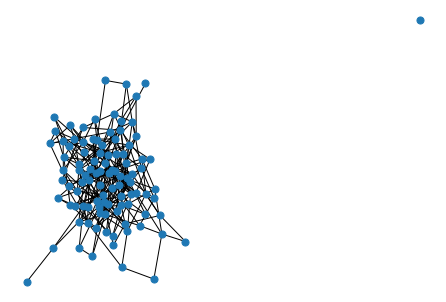

In [54]:
#draw my graph
nx.draw(myG,node_size=50)
plt.show()

## Variation

It is interesting to have the by hand version because one can easily create variant of Erdős–Rényi with some twist.

What is the next program doing? It is restricting the nodes x to be only connected to nodes between x-vertex_dist,x+vertex_dist

In [55]:
def create_erdosrenyi_variant(vertex_num: int, probability: float,vertex_dist:int):
    
    G = nx.Graph()
    G.add_nodes_from(range(vertex_num))

    for v1 in range(vertex_num):
        for v2 in range(v1, vertex_num): # go over each pair by lexicographic order
            if (v1 == v2) or (v2 >=v1+vertex_dist):
                continue # don't add self edges
            if random.uniform(0, 1) <= probability: # dra a uniform rv between 0 and 1, if smaller than p then edge
                G.add_edge(v1, v2,length=1)
    return G


In [62]:
myGV=create_erdosrenyi_variant(N,p,20)

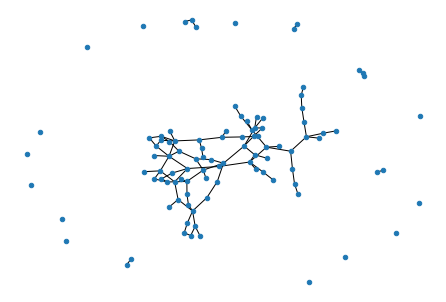

In [64]:
nx.draw(myGV,node_size=20,with_labels=False)
plt.show()

# 4) Configuration Model

The configuration model is based on a degree sequence. We will follow exactly the procedure described in the lesson:
    - duplicate each nodes as many times as its degree. We obtain stubs.
    - match these stubs one-to-one progressively.

In [126]:
# We start with a degree sequence
deg_sequence=[1,1,1,2,2,3,3,3,4]

In [127]:
# Define the auxiliary nodes/stub

def stub_list(degree:list):
    data=[]
    v=0
    for l in degree: # Loop on the list of degree
        j=0  # counter counting how many times we already added this node
        while j<l: 
            data.append(v) # add one copy of the node
            j=j+1  # update the counter.
            
        v=v+1   # go to the next node
    
    return data

In [128]:
stub_list(deg_sequence)

[0, 1, 2, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 8]

In [129]:
# Attach the nodes/stub one-to-one
def create_configuration(degree: list):
    
    G = nx.MultiGraph()  # multi graph because multi edges
    vertex_num=len(degree) # get the number of nodes from the length of the list
    G.add_nodes_from(range(vertex_num)) # create the list of nodes
    
    aux=stub_list(degree) #create the stub
    while aux!=[]:  # as long as there are still some stub
        v1=random.choice(aux) # pick one stub
        aux.remove(v1) # remove it
        v2=random.choice(aux) #pick another stub
        aux.remove(v2) # remove it
    
        G.add_edge(v1, v2,length=1) # attach the two stubs together.
    
    return G


In [130]:
# Careful, we are not handling bad degree sequence: improve the code.

In [131]:
G=create_configuration(deg_sequence)

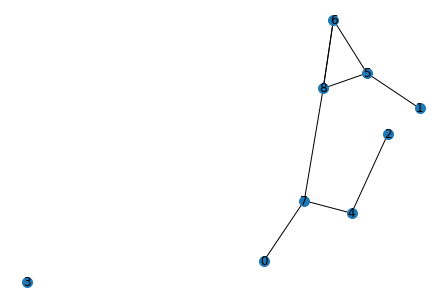

In [132]:
nx.draw(G,node_size=100,with_labels=True)
plt.show()

Notice that the obtained graph does not has the correct degree sequence. Why ?

In [133]:
A=nx.adjacency_matrix(G)
print(A)

  (0, 7)	1
  (1, 5)	1
  (2, 4)	1
  (3, 3)	1
  (4, 2)	1
  (4, 7)	1
  (5, 1)	1
  (5, 6)	1
  (5, 8)	1
  (6, 5)	1
  (6, 8)	2
  (7, 0)	1
  (7, 4)	1
  (7, 8)	1
  (8, 5)	1
  (8, 6)	2
  (8, 7)	1


# 5) Uniform Attachment

We now turn to the code for the growing random graphs.

## Creating the graph

We create a graph whith in total (vertex_num) nodes. They arrive one by one and each of them creates (edge_num) edges to precedings nodes in the graph. They attach in a uniform way.

In [89]:
def create_ua(vertex_num: int,edge_num: int):
    
    m=edge_num
    l=vertex_num    # number of nodes
    G = nx.empty_graph(m) # initialize at the minimal number of nodes for the model to bewell defined without multiedges
    
    c = (m-1) # last index of a node in the network at the current time 0,...,m-1
    
    for i in range(l): # loop to go over the sequence of arriving nodes.
        c=c+1
        liste=random.sample(range(c), m) # pick m element between 0 and c-1

        for n in liste:
            G.add_edge(c,n,length=1)

    return G

Help on random.sample: random.sample(population, k, *, counts=None)

    Return a k length list of unique elements chosen from the population sequence or set. Used for random sampling without replacement.
    
    To choose a sample from a range of integers, use a range() object as an argument. This is especially fast and space efficient for sampling from a large population: sample(range(10000000), k=60).

In [90]:
GU=create_ua(N,2)

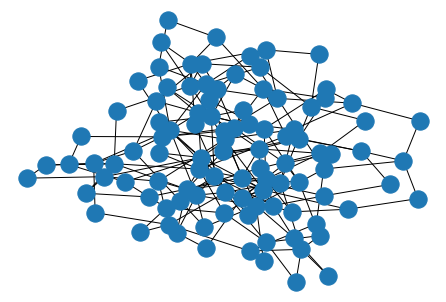

In [91]:
nx.draw(GU)

# 6) Preferential Attachment

## Package

In [92]:
GP=nx.barabasi_albert_graph(N,2)

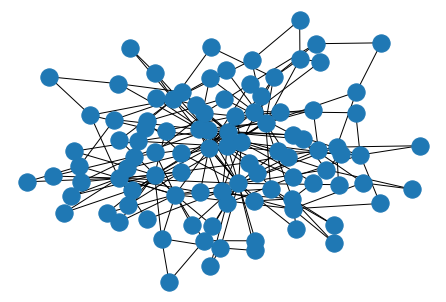

In [93]:
nx.draw(GP)

## By hand (partially)

The global structure of the program for the preferential attachement is the same as for uniform attachement, the only difference is when chosen the links. We need to use weights proportional to the degrees.

In addition, we need to be careful at the beginning when there is no link in the network.


# 7) Simulating Real Networks

We present a first approach into approximating real situation with models:
    - first step is to chose the model that seems reasonable
    - second step is to chose the parameter that are the best
    
Since we only have simple models, we have few parameters (one or two). It will lead to bad approximations. We will fix the parameters to obtain the correct number of nodes and the correct average degree. Then, we compare the diameter in both graphs.

We consider a graph and try to model it as an Erdős–Rényi model.

For the project, you need to do if for PA.

#### The graph

The number of nodes in the graph is 68.


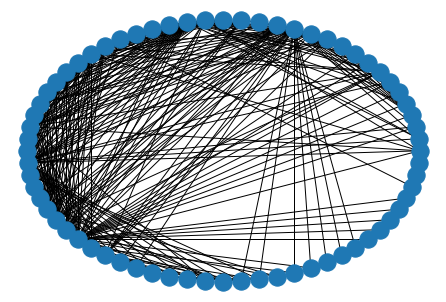

In [105]:
# Edge list for the aperitivo network
G_SNA=nx.Graph()
sna_ape = [('Wang', 'Akgun'), ('Wang', 'Kmoch'), ('Wang', 'Neuhaus'), ('Kmoch', 'Akgun'), ('Kmoch', 'Cuesta'), ('Kmoch', 'Mathis'), ('Kmoch', 'Meli'), ('Kmoch', 'Neuhaus'), ('Kmoch', 'Pisano'), ('Kmoch', 'Wang'), ('Neuhaus', 'Akgun'), ('Neuhaus', 'Cagnucci'), ('Neuhaus', 'Vasquez'), ('Neuhaus', 'Iavorskii'), ('Neuhaus', 'Kmoch'), ('Neuhaus', 'Kottage'), ('Neuhaus', 'Don'), ('Neuhaus', 'Meli'), ('Neuhaus', 'Pisano'), ('Neuhaus', 'Presaghi'), ('Neuhaus', 'Regragui'), ('Neuhaus', 'Wang'), ('Danish', 'Tabarani'), ('Di Nallo', 'Allam'), ('Di Nallo', 'Cervelli'), ('Di Nallo', 'Pinna'), ('Di Nallo', 'Presciutti'), ('Di Nallo', 'Salerno'), ('Allam', 'Abboud'), ('Allam', 'Akgun'), ('Allam', 'Azzi'), ('Allam', 'Baldoni'), ('Allam', 'Bruni'), ('Allam', 'Cervelli'), ('Allam', 'CocciÃ²'), ('Allam', 'Di'), ('Allam', 'Nallo'), ('Allam', 'Filosofi'), ('Allam', 'Kottage'), ('Allam', 'Don'), ('Allam', 'Pinna'), ('Allam', 'Pisano'), ('Allam', 'Salerno'), ('Allam', 'Sebastiani'), ('Allam', 'Torella'), ('Allam', 'Turco'), ('Allam', 'Wang'), ('Cervelli', 'Abboud'), ('Cervelli', 'Akgun'), ('Cervelli', 'Allam'), ('Cervelli', 'Andrijasevic'), ('Cervelli', 'Azzi'), ('Cervelli', 'Baldoni'), ('Cervelli', 'Benvenuti'), ('Cervelli', 'Brown'), ('Cervelli', 'Bruni'), ('Cervelli', 'Cagnucci'), ('Cervelli', 'Vasquez'), ('Cervelli', 'Cakmak'), ('Cervelli', 'Ceccarelli'), ('Cervelli', 'CocciÃ²'), ('Cervelli', 'Contino'), ('Cervelli', 'Cuesta'), ('Cervelli', 'Mathis'), ('Cervelli', 'Di'), ('Cervelli', 'Nallo'), ('Cervelli', 'Filosofi'), ('Cervelli', 'Kottage'), ('Cervelli', 'Don'), ('Cervelli', 'Laterza'), ('Cervelli', 'Pinna'), ('Cervelli', 'Pisano'), ('Cervelli', 'Presaghi'), ('Cervelli', 'Presciutti'), ('Cervelli', 'Regragui'), ('Cervelli', 'Salerno'), ('Cervelli', 'Sanna'), ('Cervelli', 'Sebastiani'), ('Cervelli', 'Tagliavini'), ('Cervelli', 'Torella'), ('Cervelli', 'Turco'), ('Azzi', 'Allam'), ('Azzi', 'Baldoni'), ('Azzi', 'Benvenuti'), ('Azzi', 'Brown'), ('Azzi', 'Bruni'), ('Azzi', 'Cervelli'), ('Azzi', 'CocciÃ²'), ('Azzi', 'Laterza'), ('Azzi', 'Pisano'), ('Azzi', 'Presaghi'), ('Azzi', 'Sanna'), ('Azzi', 'Sebastiani'), ('Azzi', 'Tabarani'), ('Azzi', 'Tagliavini'), ('Azzi', 'Torella'), ('Azzi', 'Turco'), ('Baldoni', 'Allam'), ('Baldoni', 'Aversa'), ('Baldoni', 'Baldoni'), ('Baldoni', 'Benvenuti'), ('Baldoni', 'Bruni'), ('Baldoni', 'Ceccarelli'), ('Baldoni', 'Cervelli'), ('Baldoni', 'CocciÃ²'), ('Baldoni', 'Contino'), ('Baldoni', 'Pinna'), ('Baldoni', 'Pisano'), ('Baldoni', 'Presaghi'), ('Baldoni', 'Regragui'), ('Baldoni', 'Salerno'), ('Baldoni', 'Sanna'), ('Baldoni', 'Sebastiani'), ('Baldoni', 'Tagliavini'), ('Baldoni', 'Torella'), ('Baldoni', 'Turco'), ('Baldoni', 'Wang'), ('Benvenuti', 'Akgun'), ('Benvenuti', 'Allam'), ('Benvenuti', 'Andrijasevic'), ('Benvenuti', 'Azzi'), ('Benvenuti', 'Baldoni'), ('Benvenuti', 'Benvenuti'), ('Benvenuti', 'Brown'), ('Benvenuti', 'Bruni'), ('Benvenuti', 'Cakmak'), ('Benvenuti', 'Ceccarelli'), ('Benvenuti', 'Cervelli'), ('Benvenuti', 'CocciÃ²'), ('Benvenuti', 'Contino'), ('Benvenuti', 'Danish'), ('Benvenuti', 'Di'), ('Benvenuti', 'Nallo'), ('Benvenuti', 'Fagnani'), ('Benvenuti', 'Farfan'), ('Benvenuti', 'Rodriguez'), ('Benvenuti', 'Filosofi'), ('Benvenuti', 'Goje'), ('Benvenuti', 'Kmoch'), ('Benvenuti', 'Kottage'), ('Benvenuti', 'Don'), ('Benvenuti', 'Laterza'), ('Benvenuti', 'Meli'), ('Benvenuti', 'Memedi'), ('Benvenuti', 'MIMUN'), ('Benvenuti', 'Pisano'), ('Benvenuti', 'Presaghi'), ('Benvenuti', 'Presciutti'), ('Benvenuti', 'Regragui'), ('Benvenuti', 'Sanna'), ('Benvenuti', 'Sebastiani'), ('Benvenuti', 'Tabarani'), ('Benvenuti', 'Tambini'), ('Benvenuti', 'Torella'), ('Benvenuti', 'Turco'), ('Benvenuti', 'Wang'), ('Benvenuti', 'Zannella'), ('Brown', 'El'), ('Brown', 'Arrag'), ('Bruni', 'Baldoni'), ('Bruni', 'Benvenuti'), ('Bruni', 'Sanna'), ('Contino', 'Azzi'), ('Contino', 'Baldoni'), ('Contino', 'Bruni'), ('Contino', 'Ceccarelli'), ('Contino', 'CocciÃ²'), ('Contino', 'Contino'), ('Contino', 'Di'), ('Contino', 'Nallo'), ('Contino', 'Filosofi'), ('Contino', 'Laterza'), ('Contino', 'Mancini'), ('Contino', 'Presaghi'), ('Contino', 'Regragui'), ('Contino', 'Sebastiani'), ('Contino', 'Tagliavini'), ('Contino', 'Turco'), ('Contino', 'Zannella'), ('Filosofi', 'Kottage'), ('Filosofi', 'Don'), ('Laterza', 'Abboud'), ('Laterza', 'Azzi'), ('Laterza', 'Baldoni'), ('Laterza', 'Benvenuti'), ('Laterza', 'Bruni'), ('Laterza', 'Ceccarelli'), ('Laterza', 'Cervelli'), ('Laterza', 'CocciÃ²'), ('Laterza', 'Contino'), ('Laterza', 'Di'), ('Laterza', 'Nallo'), ('Laterza', 'Fagnani'), ('Laterza', 'Filosofi'), ('Laterza', 'Kottage'), ('Laterza', 'Don'), ('Laterza', 'Pisano'), ('Laterza', 'Presaghi'), ('Laterza', 'Regragui'), ('Laterza', 'Sanna'), ('Laterza', 'Sebastiani'), ('Laterza', 'Tabarani'), ('Laterza', 'Tagliavini'), ('Laterza', 'Torella'), ('Laterza', 'Turco'), ('Laterza', 'Zannella'), ('Pisano', 'Tagliavini'), ('Presaghi', 'Akgun'), ('Presaghi', 'Allam'), ('Presaghi', 'Azzi'), ('Presaghi', 'Baldoni'), ('Presaghi', 'Benvenuti'), ('Presaghi', 'Brown'), ('Presaghi', 'Bruni'), ('Presaghi', 'Ceccarelli'), ('Presaghi', 'Cervelli'), ('Presaghi', 'CocciÃ²'), ('Presaghi', 'Contino'), ('Presaghi', 'Cuesta'), ('Presaghi', 'Mathis'), ('Presaghi', 'Danish'), ('Presaghi', 'Di'), ('Presaghi', 'Nallo'), ('Presaghi', 'El'), ('Presaghi', 'Arrag'), ('Presaghi', 'Fagnani'), ('Presaghi', 'Farfan'), ('Presaghi', 'Rodriguez'), ('Presaghi', 'Filosofi'), ('Presaghi', 'Formaro'), ('Presaghi', 'Iavorskii'), ('Presaghi', 'Jelusic'), ('Presaghi', 'Kmoch'), ('Presaghi', 'Kottage'), ('Presaghi', 'Don'), ('Presaghi', 'Krasnokutskii'), ('Presaghi', 'Laterza'), ('Presaghi', 'Meli'), ('Presaghi', 'Neuhaus'), ('Presaghi', 'Pisano'), ('Presaghi', 'Presaghi'), ('Presaghi', 'Regragui'), ('Presaghi', 'Sanna'), ('Presaghi', 'Sasso'), ('Presaghi', 'Tagliavini'), ('Presaghi', 'Turco'), ('Presaghi', 'Venel'), ('Sanna', 'Allam'), ('Sanna', 'Azzi'), ('Sanna', 'Baldoni'), ('Sanna', 'Benvenuti'), ('Sanna', 'Bruni'), ('Sanna', 'Ceccarelli'), ('Sanna', 'Cervelli'), ('Sanna', 'CocciÃ²'), ('Sanna', 'Fagnani'), ('Sanna', 'Filosofi'), ('Sanna', 'Laterza'), ('Sanna', 'Pisano'), ('Sanna', 'Presaghi'), ('Sanna', 'Regragui'), ('Sanna', 'Sebastiani'), ('Sanna', 'Tabarani'), ('Sanna', 'Tagliavini'), ('Sanna', 'Torella'), ('Sanna', 'Turco'), ('Sebastiani', 'Sanna'), ('Tagliavini', 'Allam'), ('Tagliavini', 'Azzi'), ('Tagliavini', 'Baldoni'), ('Tagliavini', 'Baranes'), ('Tagliavini', 'Benvenuti'), ('Tagliavini', 'Brown'), ('Tagliavini', 'Bruni'), ('Tagliavini', 'Cagnucci'), ('Tagliavini', 'Vasquez'), ('Tagliavini', 'Cakmak'), ('Tagliavini', 'Ceccarelli'), ('Tagliavini', 'Cervelli'), ('Tagliavini', 'CocciÃ²'), ('Tagliavini', 'Contino'), ('Tagliavini', 'Cuesta'), ('Tagliavini', 'Mathis'), ('Tagliavini', 'Desideri'), ('Tagliavini', 'Di'), ('Tagliavini', 'Nallo'), ('Tagliavini', 'Fagnani'), ('Tagliavini', 'Farfan'), ('Tagliavini', 'Rodriguez'), ('Tagliavini', 'Filosofi'), ('Tagliavini', 'Jelusic'), ('Tagliavini', 'Kmoch'), ('Tagliavini', 'Kochai'), ('Tagliavini', 'Laterza'), ('Tagliavini', 'Mancini'), ('Tagliavini', 'Meli'), ('Tagliavini', 'Memedi'), ('Tagliavini', 'Neuhaus'), ('Tagliavini', 'Pinna'), ('Tagliavini', 'Pisano'), ('Tagliavini', 'Pizzuto'), ('Tagliavini', 'Allende'), ('Tagliavini', 'Presaghi'), ('Tagliavini', 'Regragui'), ('Tagliavini', 'Sebastiani'), ('Tagliavini', 'Tabarani'), ('Tagliavini', 'Tambini'), ('Tagliavini', 'Torella'), ('Tagliavini', 'Turco'), ('Tagliavini', 'Wang'), ('Tagliavini', 'Zannella'), ('Torella', 'Allam'), ('Torella', 'Azzi'), ('Torella', 'Baldoni'), ('Torella', 'Benvenuti'), ('Torella', 'Bruni'), ('Torella', 'Ceccarelli'), ('Torella', 'Cervelli'), ('Torella', 'CocciÃ²'), ('Torella', 'Fagnani'), ('Torella', 'Filosofi'), ('Torella', 'Kottage'), ('Torella', 'Don'), ('Torella', 'Laterza'), ('Torella', 'Pinna'), ('Torella', 'Pisano'), ('Torella', 'Presaghi'), ('Torella', 'Regragui'), ('Torella', 'Salerno'), ('Torella', 'Sanna'), ('Torella', 'Sebastiani'), ('Torella', 'Tabarani'), ('Torella', 'Tambini'), ('Torella', 'Turco'), ('Torella', 'Wang'), ('Chisenga', 'Abboud'), ('Krasnokutskii', 'Krasnokutskii'), ('Fagnani', 'Allam'), ('Fagnani', 'Benvenuti'), ('Fagnani', 'El'), ('Fagnani', 'Arrag'), ('Fagnani', 'Farfan'), ('Fagnani', 'Rodriguez'), ('Fagnani', 'Kottage'), ('Fagnani', 'Don'), ('Fagnani', 'Laterza'), ('Fagnani', 'Regragui'), ('Fagnani', 'Tambini'), ('Fagnani', 'Torella'), ('Memedi', 'El'), ('Memedi', 'Arrag'), ('Memedi', 'Farfan'), ('Memedi', 'Rodriguez'), ('Aversa', 'Formaro'), ('Bernardini', 'Augello'), ('Bernardini', 'Desideri')]
# Build the graph from the edge list
G_SNA = nx.from_edgelist(sna_ape)

# Number of nodes
N_SNA = G_SNA.number_of_nodes()
print('The number of nodes in the graph is ' + str(N_SNA) + '.')

# Circular plot
nx.draw_circular(G_SNA)   

#### Average degree

The average degree is given by the sum of all degrees divided by the number of nodes.

In [106]:
total_deg= sum(span for n, span in G_SNA.degree())
k_SNA=total_deg/(G_SNA.number_of_nodes())
print('The average degree is:')
print(k_SNA)

The average degree is:
9.0


#### Simulating

We start y setting the correct number of nodes

In [107]:
N=N_SNA

We now want to set correctly the parameter to obtain the correct average degree in the random graph model:

    - for an Erdős–Rényi with n nodes and parameter p, the expected average degree is p(n-1)=k. 
    Hence on need to pick p=k/(n-1).
    
    - for a growing Random graph where one node arrives per stage and create m links, the average degree is equal to 2m. 
    Hence, one need to pick m=k/2
    
    - for another model, one can either try to compute theoreticaly what parameters is the correct one or try a trial and error approach by trying different parameters.
    

Following the previous block, we set p=k/(n-1)

In [108]:
p_sim=k_SNA/(N-1)
print(p_sim)

0.13432835820895522


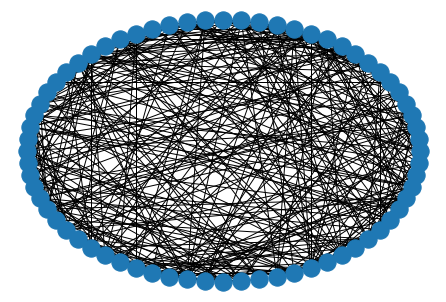

In [117]:
# We now that in an Erdos graph, the expected degree is p(n-1) so we need to pick p equal to expected degree/(n-1)
G2= create_erdosrenyi(N_SNA,p_sim)

nx.draw_circular(G2)

#### Comparing degree distribution

In [118]:
G2.number_of_edges()

323

In [112]:
G_SNA.number_of_edges()

306

#### Comparing Diameter

We now compare the diameter. Since the graph are not connected, we first extract the main component

In [121]:
largest_cc_SNA = max(nx.connected_components(G_SNA), key=len)
G_SNA_main=G_SNA.subgraph(largest_cc_SNA)

nx.diameter(G_SNA_main)

6

In [122]:
largest_cc_2 = max(nx.connected_components(G2), key=len)
G2_main=G2.subgraph(largest_cc_2)

nx.diameter(G2_main)

4

They are different. One is 2/3 of the other one. The random graph approximation seems not very good (This is expected)

Lets compare degree distribution

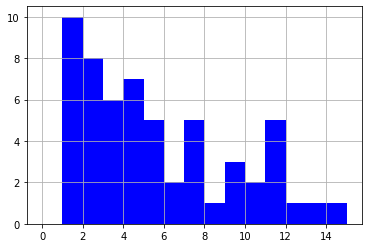

In [123]:
data_degree=[G_SNA.degree(n) for n in G_SNA.nodes()] # List of degrees
pt = plt.hist(data_degree, bins=range(16),facecolor='blue')  #histogram of the date set data_centralities
plt.grid(True)
plt.show()

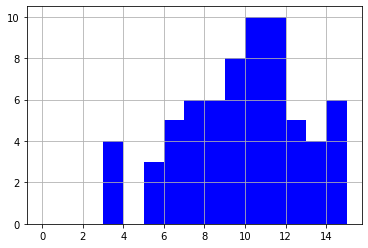

In [124]:
data_degree=[G2_main.degree(n) for n in G2_main.nodes()] # List of degrees
pt = plt.hist(data_degree, bins=range(16),facecolor='blue')  #histogram of the date set data_centralities
plt.grid(True)
plt.show()

They are very different. This is clearly not a good approximation